In [1]:
import re
import nltk

import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

from sklearn.feature_selection.univariate_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random
import itertools

import sys
import os
import argparse
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
import six
from abc import ABCMeta
from scipy import sparse
from scipy.sparse import issparse
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y, check_array
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.preprocessing import normalize, binarize, LabelBinarizer
from sklearn.svm import LinearSVC

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
df = pd.read_csv('./Amazon_Unlocked_Mobile.csv')

### Data Preprocessing

In [3]:
df = df.dropna(subset= ['Brand Name', 'Reviews'])
#df.dropna(subset) : 특정 컬럼만 지정하여 결측치 제거 

In [4]:
df

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
...,...,...,...,...,...,...
413835,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,another great deal great price,0.0
413836,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,Ok,0.0
413837,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,Passes every drop test onto porcelain tile!,0.0
413838,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,I returned it because it did not meet my needs...,0.0


In [5]:
df.isnull().sum()
#결측치들이 사라진것을 확인 
#Price, Review Votes의 개수가 줄어든이유
#Brand Name과 Reviews결측치에도 포함되어 있었기때문

Product Name        0
Brand Name          0
Price            4115
Rating              0
Reviews             0
Review Votes    10306
dtype: int64

### Rating Mapping

In [6]:
Review_mapping =  {0: '0',1 : '0', 2 :'0',3 : '0', 4 : '1', 5 : '1'}
Review_mapping

{0: '0', 1: '0', 2: '0', 3: '0', 4: '1', 5: '1'}

In [7]:
Rating = lambda x: Review_mapping.get(x,x)
df['Rating']=df.Rating.map(Rating)

In [8]:
df['Rating'].unique()

array(['1', '0'], dtype=object)

### Text Analysis

In [9]:
df.columns

Index(['Product Name', 'Brand Name', 'Price', 'Rating', 'Reviews',
       'Review Votes'],
      dtype='object')

In [10]:
a = df.iloc[:,3]
print(a)

0         1
1         1
2         1
3         1
4         1
         ..
413835    1
413836    0
413837    1
413838    0
413839    1
Name: Rating, Length: 348623, dtype: object


In [20]:
b = df.iloc[:,4]

In [21]:
doc = pd.concat([a,b], axis = 1)

In [22]:
train_docs = doc

In [23]:
train_docs, test_docs = train_test_split(train_docs, test_size = 0.3)

In [24]:
train_docs

,Rating,Reviews
122223,1,Its an excellent inexpensive phone with 2 sim-...
375154,0,They say factory unlocked and the seal was bro...
125836,0,"This is my 5th Blu phone, and if you can get t..."
113547,1,Good
333392,0,Samsung is a rip-off . This is the worst type ...
...,...,...
121020,1,Congratulecion
365813,1,"Excellent phone, it works at expected"
261704,1,This phone meets the requirements I expected. ...
254311,1,"Nice phone, just as expected. Almost stock And..."


In [25]:
test_docs

,Rating,Reviews
110534,0,"Nothing but problems....My apps close all the,..."
1932,1,"I'm no expert in smartphones , I'm only a comm..."
274214,1,A very nice and stylish entry smartphone level...
133600,1,Awesome product love it ''''''''''''''''''''''...
382742,1,One of the most economic and amazing cellphone...
...,...,...
315996,0,I have returned the item. I somehow expected i...
130110,1,Excellent quality for a good price. Unlocked t...
25221,1,Excellent condition!
164800,0,it is not working and leave me stranded in a a...


In [26]:
doc

,Rating,Reviews
0,1,I feel so LUCKY to have found this used (phone...
1,1,"nice phone, nice up grade from my pantach revu..."
2,1,Very pleased
3,1,It works good but it goes slow sometimes but i...
4,1,Great phone to replace my lost phone. The only...
...,...,...
413835,1,another great deal great price
413836,0,Ok
413837,1,Passes every drop test onto porcelain tile!
413838,0,I returned it because it did not meet my needs...


In [27]:
def review_to_wordlist(review, remove_stopwords = True):

    
    review_text = re.sub('[^a-zA-Z]'," ", review)
    #review_text에 영어만 넣기 
    
    words = review_text.lower().split()
    #소문자로 바꿔주고 그것들을 분리해준다 
    
    if remove_stopwords:
        stops = set(stopwords.words('english'))
        words = [w for w in words if not w in stops]
        #stops에 영어의 불용어를 넣어줌 
        #words는 소문자로 변환되고 띄어져있는 것이며 
        #stops에 있는 불용어를 제외하고 넣어줌 
        
    b = []
    stemmer = english_stemmer
    for word in words:
        b.append(stemmer.stem(word))
        #words에 전처리된것들의 어간들만 추출 
        
    return(b)


In [28]:
clean_train_reviews = []
for review in train_docs['Reviews']:
    clean_train_reviews.append( " ".join(review_to_wordlist(review)))
    
clean_test_reviews = []
for review in test_docs['Reviews']:
    clean_test_reviews.append( " ".join(review_to_wordlist(review)))

In [29]:
a= pd.DataFrame(clean_train_reviews)
#리스트를 데이터프레임 형태로 변환 

In [30]:
a.columns = ['Reviews']

In [31]:
a

,Reviews
0,excel inexpens phone sim slot use phone line y...
1,say factori unlock seal broken mobil look like...
2,th blu phone get phone sale great valu money f...
3,good
4,samsung rip worst type phone world left commen...
...,...
244031,congratulecion
244032,excel phone work expect
244033,phone meet requir expect flip design outsid sc...
244034,nice phone expect almost stock android coupl n...


In [32]:
b = pd.DataFrame(clean_test_reviews)
b.columns = ['Reviews']

In [33]:
len(a)

244036

In [35]:
c = train_docs['Rating']
d = test_docs['Rating']

In [36]:
len(c)

244036

In [37]:
train = pd.concat([a,c], axis = 1)
test = pd.concat([b,d], axis = 1)

In [38]:
train.isnull().sum()
#이게 왜 생기는지 모르겠음

Reviews    98558
Rating     98558
dtype: int64

In [39]:
test.isnull().sum()

Reviews    79753
Rating     79753
dtype: int64

In [40]:
train = train.dropna()
test = test.dropna()

In [41]:
train

,Reviews,Rating
0,excel inexpens phone sim slot use phone line y...,1
2,th blu phone get phone sale great valu money f...,1
3,good,1
4,samsung rip worst type phone world left commen...,1
5,month receiv mobil start anymor,0
...,...,...
244027,excel phone everyth touch full keyboard multip...,0
244028,great,1
244030,say much got phone work love look though sleek...,1
244033,phone meet requir expect flip design outsid sc...,1


# ================ 5/1

### LSTM

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [64]:
max_words = 50000
max_len = 30
batch_size = 128
EPOCHS = 30

In [44]:
#중요
#__init__, __call__은 네트워크 구조를 짜고 불러올떄 어떻게 실행되는지 구성하는거 
class SimpleLSTM(tf.keras.Model):
    def __init__(self): #구조를 짠다고 생각 
        super().__init__()
        self.emb = Embedding(max_words, 100)
        self.lstm = LSTM(128, dropout = 0.3, recurrent_dropout = 0.3)#dropout을 사용하면 오버피팅가능성이 줄어든다
        self.dense = Dense(1, activation = 'sigmoid')#dense에 활성화함수 sigmoid를 사용한다
        
    def __call__(self, x, training= None, mask=None):#init를 불러서 쓸때 사용
        x = self.emb(x)
        x = self.lstm(x)
        return self.dense(x)

In [46]:
x_train = train['Reviews']
x_test = test['Reviews']

y_train = train['Rating']
y_test = test['Rating']

In [47]:
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(x_train)

In [48]:
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(x_test)

In [51]:
len(x_train)

145478

In [50]:
len(y_train)

145478

In [53]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, value = 0, padding = 'pre', maxlen = max_len)
x_test = pad_sequences(x_test, value = 0, padding = 'pre', maxlen = max_len)

In [54]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [55]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [56]:
model = SimpleLSTM()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [65]:
earlystopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)

In [66]:
history = model.fit(train_ds, validation_data = test_ds, epochs = EPOCHS, callbacks = [earlystopper] )

Epoch 1/30
1137/1137 [==============================] - 178s 157ms/step - loss: 0.5801 - accuracy: 0.7001 - val_loss: 0.6430 - val_accuracy: 0.6810
Epoch 2/30
1137/1137 [==============================] - 178s 157ms/step - loss: 0.5657 - accuracy: 0.7092 - val_loss: 0.6760 - val_accuracy: 0.6650
Epoch 3/30
1137/1137 [==============================] - 179s 157ms/step - loss: 0.5521 - accuracy: 0.7169 - val_loss: 0.7016 - val_accuracy: 0.6800
Epoch 4/30
1137/1137 [==============================] - 179s 157ms/step - loss: 0.5414 - accuracy: 0.7230 - val_loss: 0.7344 - val_accuracy: 0.6697
Epoch 5/30
1137/1137 [==============================] - 177s 155ms/step - loss: 0.5317 - accuracy: 0.7287 - val_loss: 0.7792 - val_accuracy: 0.6466
Epoch 6/30
1137/1137 [==============================] - 177s 155ms/step - loss: 0.5222 - accuracy: 0.7341 - val_loss: 0.8198 - val_accuracy: 0.6671
Epoch 7/30
1137/1137 [==============================] - 177s 155ms/step - loss: 0.5140 - accuracy: 0.7391 - val_

In [67]:
score, acc =model.evaluate(x_test, y_test, batch_size = batch_size)

195/195 [==============================] - 4s 19ms/step - loss: 0.9288 - accuracy: 0.6386


In [68]:
print('Test Score:' , score)
print('Test Accuracy:' , acc)

Test Score: 0.928786039352417
Test Accuracy: 0.6386405825614929


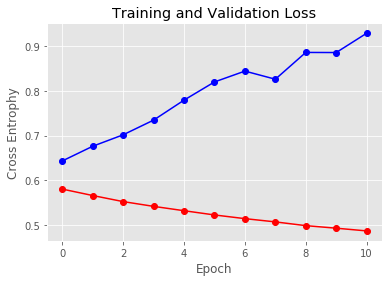

In [69]:
#val_loss가() 올라가면 기본적으로 오버피팅이 되고 있다는 뜻
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'ro-', label = 'train_loss')
plt.plot(val_loss, 'bo-', label = 'val_loss')
plt.ylabel('Cross Entrophy')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

